[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rndsrc/orbits-py/blob/main/handson.ipynb)

# Speeding Up Your Python Codes 1000x

## Introduction

Welcome to "Speeding Up Your Python Codes 1000x"!

In the next 45 minutes, we will learn tricks to unlock python performance and increase a sample code's speed by a factor of 1000x!

Here is our plan:
* **Understand the problem:**
  we will start by outlining the $n$-body problem and how to use the leapfrog algorithm to solve it numerically.
* **Benchmark and profile:**
  we will learn how to measure performance and identify bottlenecks using tools like timeit and cProfile.
* **Optimize the code:**
  step through a series of optimizations:
  * Use list comprehensions and reduce operation counts.
  * Replace slow operations with faster ones.
  * Leverage high-performance libraries such as NumPy.
  * Explore lower precision where applicable.
  * Harness Google JAX for just-in-time compilation and GPU acceleration.
* **Apply the integrator:** Finally, we will use our optimized code to simulate the mesmerizing figure-8 self-gravitating orbit.

By the end of this workshop, you will see that Python isn't just great for rapid prototyping.
It can also deliver serious performance when optimized right. Let’s dive in!

## The $n$-body Problem and the Leapfrog Algorithm

The $n$-body problem involves simulating the motion of many bodies interacting with each other through (usually) gravitational forces.

This problem is physically interesting, as it models the [solar system](https://rebound.readthedocs.io/en/latest/), [galaxy dynamics, or even the whole cosmic structure formation](https://wwwmpa.mpa-garching.mpg.de/gadget/)!

This problem is also computational interesting.
Each body experiences a force from every other body, making the simulation computationally intensive.
It is ideal for exploring optimization techniques.

The leapfrog algorithm is a simple, robust numerical integrator that alternates between updating velocities ("kicks") and positions ("drifts").
It is popular because it conserves energy and momentum well over long simulation periods.

We need to solve Newton's second law of motion for a collection of $n$ bodies.
The body forces are solved by using Newton's Law of Universal Gravitation.

### Gravitational Force/Acceleration Equation

For any two bodies labeled by $i$ and $j$, the direct gravitational force exerted on body $i$ by body $j$ is given by:
\begin{align}
  \mathbf{f}_{ij} = -G m_i m_j\frac{\mathbf{r}_i - \mathbf{r}_j\ \ \ }{|\mathbf{r}_i - \mathbf{r}_j|^{3/2}},
\end{align}
where:
* $G$ is the gravitational constant.
* $m_i$ and $m_j$ are the masses of the bodies.
* $\mathbf{r}_i$ and $\mathbf{r}_j$ are their position vectors.

Summing the contributions from all other bodies gives the net force (and thus the acceleration) on body $i$:
\begin{align}
  \mathbf{f}_i
  = \sum_{j\ne i} \mathbf{f}_{ij}
  = -G m_i \sum_{j\ne i} m_j \frac{\mathbf{r}_i - \mathbf{r}_j\ \ \ }{|\mathbf{r}_i - \mathbf{r}_j|^3},
\end{align}

Given Newton's law $f = m a$, the "acceleration" applied on body $i$ caused by all other bodies is:
\begin{align}
  \mathbf{a}_i
  = \sum_{j\ne i} \mathbf{a}_{ij}
  = -G \sum_{j\ne i} m_j \frac{\mathbf{r}_i - \mathbf{r}_j\ \ \ }{|\mathbf{r}_i - \mathbf{r}_j|^3}.
\end{align}

Choosing the right units so $G = 1$.
Here is a pure Python implementation of the gravitational acceleration:

In [1]:
def acc1(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                axij = - m[j] * (xi - xj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)
                ayij = - m[j] * (yi - yj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)
                azij = - m[j] * (zi - zj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

We may try using this function to evaluate the gravitational force between two particles, with with mass $m = 1$, at a distance of $2$.
We expect the "acceleration" be -1/4 in the direction of their seperation.

In [2]:
m  = [1.0, 1.0]
r0 = [
    (+1.0, 0.0, 0.0),
    (-1.0, 0.0, 0.0),
]
a0ref = [
    (-0.25, 0.0, 0.0),
    (+0.25, 0.0, 0.0),
]

In [3]:
a0 = acc1(m, r0)

In [4]:
a0

[(-0.25, 0.0, 0.0), (0.25, 0.0, 0.0)]

In [5]:
assert a0 == a0ref

### Leapfrog Integrator

Our simulation solves Newton's second law of motion, $\mathbf{f} = m \mathbf{a}$, numerically.
The equation tells us that the acceleration of a body is determined by the net force acting on it.
In a system where forces are conservative, this law guarantees the conservation of energy and momentum.
These are critical properties when simulating long-term dynamics.

However, many standard integration methods tend to drift over time, gradually losing these conservation properties.
The leapfrog algorithm is a symplectic integrator designed to address this issue.
Its staggered (or "leapfrogging") updates of velocity and position help preserve energy and momentum much more effectively over extended simulations.

1. Half-step velocity update (Kick):
   start by updating the velocity by half a time step using the current acceleration $a(t)$:
   \begin{align}
     v\left(t+\frac{1}{2}\Delta t\right) = v(t) + \frac{1}{2}\Delta t\, a(t).
   \end{align}

2. Full-step position update (Drift):
   update the position for a full time step using the half-stepped velocity:
   \begin{align}
     x(t+\Delta t) = x(t) + \Delta t\, v\left(t+\frac{1}{2}\Delta t\right).
   \end{align}

3. Half-step velocity update (Kick):
   finally, update the velocity by another half time step using the new acceleration $a(t+\Delta t)$ computed from the updated positions:
   \begin{align}
     v(t+\Delta t) = v\left(t+\frac{1}{2}\Delta t\right) + \frac{1}{2}\Delta t\, a(t+\Delta t).
   \end{align}

Here is a pure Python implementation of the gravitational acceleration:

In [6]:
def leapfrog1(m, r0, v0, dt, acc=acc1):

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    a0 = acc(m, r0)
    vh = []
    for i in range(n):
        a0xi, a0yi, a0zi = a0[i]
        v0xi, v0yi, v0zi = v0[i]
        vhxi = v0xi + 0.5 * dt * a0xi
        vhyi = v0yi + 0.5 * dt * a0yi
        vhzi = v0zi + 0.5 * dt * a0zi
        vh.append((vhxi, vhyi, vhzi))

    # r1 = r0 + dt * vh
    r1 = []
    for i in range(n):
        vhxi, vhyi, vhzi = vh[i]
        x0i,  y0i,  z0i  = r0[i]
        x1i = x0i + dt * vhxi
        y1i = y0i + dt * vhyi
        z1i = z0i + dt * vhzi
        r1.append((x1i, y1i, z1i))

    # v1 = vh + 0.5 * dt * a1
    a1 = acc(m, r1)
    v1 = []
    for i in range(n):
        a1xi, a1yi, a1zi = a1[i]
        vhxi, vhyi, vhzi = vh[i]
        v1xi = vhxi + 0.5 * dt * a1xi
        v1yi = vhyi + 0.5 * dt * a1yi
        v1zi = vhzi + 0.5 * dt * a1zi
        v1.append((v1xi, v1yi, v1zi))

    return r1, v1

We may try using this function to evolve the two particles under gravitational force, with some initial velocities.

In [7]:
v0 = [
    (0.0, +0.5, 0.0),
    (0.0, -0.5, 0.0),
]
v1ref = [
    (-0.024984345739803245, +0.4993750014648409, 0.0),
    (+0.024984345739803245, -0.4993750014648409, 0.0),
]

In [8]:
r1, v1 = leapfrog1(m, r0, v0, 0.1)

In [9]:
v1

[(-0.024984345739803245, 0.4993750014648409, 0.0),
 (0.024984345739803245, -0.4993750014648409, 0.0)]

In [10]:
assert v1 == v1ref

### Test the Integrator

We test the integrator by evolving the two particle by a time $T = 2\pi$ using $N = 64$ steps.

In [11]:
from math import pi

N = 64
T = 2 * pi

In [12]:
dt = T / N
R  = [r0]
V  = [v0]
for _ in range(N):
    r, v = leapfrog1(m, R[-1], V[-1], dt)
    R.append(r)
    V.append(v)

Although our numerical scheme is implemented in pure python, it is still handy to use `numpy` to slice through the data...

In [13]:
import numpy as np

R = np.array(R)
X = R[:,:,0]
Y = R[:,:,1]

and plot the result...

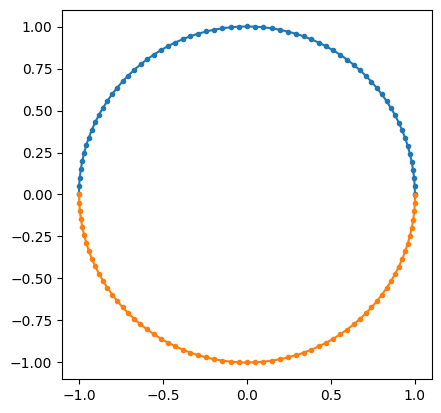

In [14]:
from matplotlib import pyplot as plt

plt.plot(X, Y, '.-')
plt.gca().set_aspect('equal')

In addition, we may create animation.

In [15]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
from tqdm import tqdm

def animate(X, Y, ntail=10):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    frames = []
    for i in tqdm(range(len(X))):
        b,e = max(0, i-ntail), i+1
        ax.set_prop_cycle(None)
        f = ax.plot(X[b:e,:], Y[b:e,:], '.-', animated=True)
        frames.append(f)

    anim = ArtistAnimation(fig, frames, interval=50)
    plt.close()

    return anim

In [16]:
anim = animate(X, Y)

HTML(anim.to_html5_video())  # display animation
# anim.save('orbitss.mp4')  # save animation

100%|██████████| 65/65 [00:00<00:00, 1177.89it/s]


## Benchmarking and Profiling Your Code

Before diving into optimizations, it is essential to understand where our code spends most of its time.
By benchmarking and profiling, we can pinpoint performance bottlenecks and measure improvements after optimization.

### Benchmarking vs. Profiling

* Benchmarking:
  Measures the overall runtime of your code.
  Tools like Python's `timeit` module run your code multiple times to provide an accurate average runtime.
  This helps in comparing the performance before and after optimizations.

* Profiling:
  Provides detailed insights into which parts of your code are consuming the most time.
  For example, `cProfile` generates reports showing function call times and frequencies.
  Note that `cProfile` typically runs the code once, so its focus is on identifying hotspots rather than providing averaged timings.

### Quick Benchmark Example

`timeit` is a module designed for benchmarking by executing code multiple times.
It is excellent for obtaining reliable runtime measurements.

In [17]:
n  = 1000
m  = np.random.lognormal(size=n).tolist()
r0 = np.random.normal(size=(n, 3)).tolist()
v0 = np.random.normal(size=(n, 3)).tolist()

In [18]:
%timeit r1, v1 = leapfrog1(m, r0, v0, dt)

2.91 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes about 1.31 second on my laptop to run a single step of leapfrog for $n = 1000$ bodies.
Your mileage may vary.
But this is pretty slow in today's standard.

### Quick Profiling Example

Here is a snippet using cProfile to profile our leapfrog stepper:

In [19]:
import cProfile

cProfile.run("r1, v1 = leapfrog1(m, r0, v0, dt)")

         5009 function calls in 4.497 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    4.493    2.246    4.494    2.247 <ipython-input-1-a7dddb8ba81d>:1(acc1)
        1    0.003    0.003    4.497    4.497 <ipython-input-6-4586828ed662>:1(leapfrog1)
        1    0.000    0.000    4.497    4.497 <string>:1(<module>)
        1    0.000    0.000    4.497    4.497 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     5000    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




From cProfile's result, the most used function is `method 'append' of 'list' objects`.
This is not surprising given we've been using for-loop and append, e.g.,
```
    v1 = []
    for i in range(n):
        ...
        v1.append(...)
```
in both `acc1()` and `leapfrog1()`.
This is neither pythonic nor efficient.

## Optimization 1: Use List Comprehension Over For Loop

Python's list comprehensions is a concise way to create lists by iterating over an iterable and applying an expression---all in a single, compact line.
Internally, they are optimized in `C`, making them generally faster than a standard python for-loop.

In [20]:
iterable = range(10)

# Standard python for-loop
l1 = []
for x in iterable:
    l1.append(x * 2)

# Using a list comprehension
l2 = [x * 2 for x in iterable]

# Compare results
print(l1)
print(l2)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


We may use list comprehension to rewrite our leapfrog algorithm:

In [21]:
# O1. Use List Comprehension Over For Loop

def leapfrog2(m, r0, v0, dt, acc=acc1):

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    a0 = acc(m, r0)
    vh = [[v0xi + 0.5 * dt * a0xi
               for v0xi, a0xi in zip(v0i, a0i)]
               for v0i,  a0i  in zip(v0,  a0 )]

    # TODO: use list comprehension to rewrite the remaining of our leapfrog algorithm

In [22]:
# O1. Use List Comprehension Over For Loop

def leapfrog2(m, r0, v0, dt, acc=acc1):

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    a0 = acc(m, r0)
    vh = [[v0xi + 0.5 * dt * a0xi
               for v0xi, a0xi in zip(v0i, a0i)]
               for v0i,  a0i  in zip(v0,  a0 )]

    # r1 = r0 + dt * vh
    r1 = [[x0i + dt * vhxi
               for x0i, vhxi in zip(r0i, vhi)]
               for r0i, vhi  in zip(r0,  vh )]

    # v1 = vh + 0.5 * dt * a1
    a1 = acc(m, r1)
    v1 = [[vhxi + 0.5 * dt * a1xi
               for vhxi, a1xi in zip(vhi, a1i)]
               for vhi,  a1i, in zip(vh,  a1 )]

    return r1, v1

In [23]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt)

2.76 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
cProfile.run("r1, v1 = leapfrog2(m, r0, v0, dt)")

         5009 function calls in 5.750 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    5.743    2.872    5.745    2.872 <ipython-input-1-a7dddb8ba81d>:1(acc1)
     1000    0.002    0.000    0.002    0.000 <ipython-input-22-8a4e2d0e2fe3>:14(<listcomp>)
     1000    0.001    0.000    0.001    0.000 <ipython-input-22-8a4e2d0e2fe3>:20(<listcomp>)
        1    0.000    0.000    5.753    5.753 <ipython-input-22-8a4e2d0e2fe3>:3(leapfrog2)
     1000    0.002    0.000    0.002    0.000 <ipython-input-22-8a4e2d0e2fe3>:9(<listcomp>)
        1    0.000    0.000    5.753    5.753 <string>:1(<module>)
        1    0.000    0.000    5.753    5.753 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     2000    0.002    0.000    0.002    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects

Depending on your python version, you may see slight performance increase from `timeit` and number of call decreased for `append`.
It takes about 1.29 second on my laptop to run a single step of leapfrog for $n = 1000$ bodies.

## Optimization 2: Reduce Operation Count

Reducing the operation count means cutting down on unnecessary calculations and redundant function calls.
When operations are executed millions of times---as in inner loops or simulations---even small optimizations can yield significant speed improvements.

For example, precomputing constant values or combining multiple arithmetic steps into one reduces repetitive work.
In the context of the $n$-body problem, calculate invariant quantities once outside of critical loops instead of recalculating them every time.
This streamlined approach not only speeds up your code but also help further optimizations like vectorization and JIT compilation.

Recall the benchmark using `leapfrog2()` with `acc1()`.

In [25]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc1)

2.91 s ± 422 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We noticed that the computation of $\mathbf{r}_{ij}^3 = |\mathbf{r}_i - \mathbf{r}_j|^3$ is used in all components of $\mathbf{x}_{ij}$.
Instead of recomputing it, we can simply cache it in a variable `rrr`.

In [26]:
# O2a. "Cache" r^3

def acc2(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                # TODO: "Cache" r^3 below
                axij = - m[j] * (xi - xj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)
                ayij = - m[j] * (yi - yj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)
                azij = - m[j] * (zi - zj) / ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

In [27]:
# O2a. "Cache" r^3

def acc2(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                # "Cache" r^3
                rrr = ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)

                axij = - m[j] * (xi - xj) / rrr
                ayij = - m[j] * (yi - yj) / rrr
                azij = - m[j] * (zi - zj) / rrr

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

In [28]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc2)

1.48 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This reduce the benchmark time by about 45% already!

But we don't have to stop from this.
The different components of $\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j$ can be cached as `dx`, `dy`, `dz`, too.

In [29]:
# O2b. "Cache" the components of dr = r_ij = ri - rj

def acc3(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                # TODO: "Cache" the components of dr = r_ij = ri - rj
                rrr = ((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)**(3/2)

                axij = - m[j] * (xi - xj) / rrr
                ayij = - m[j] * (yi - yj) / rrr
                azij = - m[j] * (zi - zj) / rrr

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

In [30]:
# O2b. "Cache" the components of dr = r_ij = ri - rj

def acc3(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                # "Cache" the components of dr = r_ij = ri - rj
                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)

                axij = - m[j] * dx / rrr
                ayij = - m[j] * dy / rrr
                azij = - m[j] * dz / rrr

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

In [31]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc3)

1.42 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Similarly, we can cache $-m_j / |\mathbf{r}_{ij}|^3$.

In [32]:
# O2c. "cache" -m_j / r_{ij}^3

def acc4(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)

                # TODO: "cache" -m_j / r_{ij}^3
                axij = - m[j] * dx / rrr
                ayij = - m[j] * dy / rrr
                azij = - m[j] * dz / rrr

                axi += axij
                ayi += ayij
                azi += azij

        a.append((axi, ayi, azi))

    return a

In [33]:
# O2c. "cache" -m_j / r_{ij}^3

def acc4(m, r):

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)
                f   = - m[j] / rrr # "cache" -m_j / r_{ij}^3

                axi += f * dx
                ayi += f * dy
                azi += f * dz

        a.append((axi, ayi, azi))

    return a

In [35]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc4)

1.29 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally, we notice the symmetry that $\mathbf{a}_{ij} = \mathbf{a}_{ji}$.
In principle, we only need to compute $\mathbf{a}_{ij}$ for $j < i$.
However, this requires we pre-allocate a list-of-list.
Just creating list-of-list and use them to keep track of the acceleration actually increase benchmark time.

In [36]:
# O2d. Use list-of-list to keep track of the acceleration

def acc5(m, r):

    n = len(m)
    a = [] # TODO: create a list-of-list
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)
                f   = - m[j] / rrr

                # TODO: Use the list-of-list to keep track of the acceleration
                axi += f * dx
                ayi += f * dy
                azi += f * dz

        a.append((axi, ayi, azi))

    return a

In [37]:
# O2d. Use list-of-list to keep track of the acceleration

def acc5(m, r):

    n = len(m)
    a = [[0]*3]*n # create a list-of-list
    for i in range(n):
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)
                f   = - m[j] / rrr

                # Use the list-of-list to keep track of the acceleration
                a[i][0] += f * dx
                a[i][1] += f * dy
                a[i][2] += f * dz

    return a

In [38]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc5)

1.46 s ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


But once we have the list-of-list, we may change the upper bound of the inner loop to cut the computation to almost half.
This is the fastest code so far.

In [39]:
# O2e. Take advantage of the symmetry of a_ij

def acc6(m, r):

    n = len(m)
    a = [[0]*3]*n
    for i in range(n):
        for j in range(n): # TODO: adjust the upper bound of the inner loop
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2)
                f   = - m[j] / rrr

                a[i][0] += f * dx
                a[i][1] += f * dy
                a[i][2] += f * dz

                # TODO: Account the acceleration to the j-th body.

    return a

In [40]:
# O2e. Take advantage of the symmetry of a_ij

def acc6(m, r):

    n = len(m)
    a = [[0]*3]*n
    for i in range(n):
        for j in range(i): # adjust the upper bound of the inner loop
            xi, yi, zi = r[i]
            xj, yj, zj = r[j]

            dx = xi - xj
            dy = yi - yj
            dz = zi - zj

            rrr = (dx**2 + dy**2 + dz**2)**(3/2)
            fi  =   m[i] / rrr
            fj  = - m[j] / rrr

            a[i][0] += fj * dx
            a[i][1] += fj * dy
            a[i][2] += fj * dz

            # Account the acceleration to the j-th body.
            a[j][0] += fi * dx
            a[j][1] += fi * dy
            a[j][2] += fi * dz

    return a

In [41]:
%timeit r1, v1 = leapfrog2(m, r0, v0, dt, acc=acc6)

987 ms ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, `acc?()` is not the only function we can optimize to reduce operation count.
If we study `leapfrog?()` carefully, the acceleration `a` in the second "kick" calculation can actually be reused by the first "kick" of the next step.
This requires modifying the function prototype a bit.

In [42]:
# O2f. Reuse computation

def leapfrog3(m, r0, v0, a0, dt, acc=acc6):

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    # a0 = acc(m, r0) <--- we comment this out, and reuse the acceleration computed in the second "kick" of the previous step
    vh = [[v0xi + 0.5 * dt * a0xi
               for v0xi, a0xi in zip(v0i, a0i)]
               for v0i,  a0i  in zip(v0,  a0 )]

    # r1 = r0 + dt * vh
    r1 = [[x0i + dt * vhxi
               for x0i, vhxi in zip(r0i, vhi)]
               for r0i, vhi  in zip(r0,  vh )]

    # v1 = vh + 0.5 * dt * a1
    a1 = acc(m, r1)
    v1 = [[vhxi + 0.5 * dt * a1xi
               for vhxi, a1xi in zip(vhi, a1i)]
               for vhi,  a1i, in zip(vh,  a1 )]

    return r1, v1, a1 # <--- to reuse the acceleration computed in the second "kick", let's return it.

In [43]:
# Precompute `a0`
a0 = acc4(m, r0)

In [44]:
%timeit r1, v1, a1 = leapfrog3(m, r0, v0, a0, dt, acc=acc4)

563 ms ± 8.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit r1, v1, a1 = leapfrog3(m, r0, v0, a0, dt, acc=acc6)

476 ms ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Remarkable, it takes about 241ms on my laptop to run a single step of leapfrog for $n = 1000$ bodies.
This is almost a 92% reduction in benchmark time!!!

## Optimizing 3: Use Fast Operations

Certain operations in Python can be surprisingly slow.
For example, the power operator (`**`) often calls C's pow() function, which for non-integer or variable exponents is typically implemented as:
\begin{align}
  x^y = \exp[y \cdot \ln(x)]
\end{align}
This method involves calculating a logarithm, a multiplication, and an exponential---operations that are much slower than simple multiplication.

For instance, if you need to square a number, it's much faster to write `x*x` rather than `x**2`.
When the exponent is a known small integer, manually multiplying the base is usually the quickest route.

By choosing fast operations over more generic ones, you can shave off microseconds in code that runs millions of times, ultimately contributing to some performance boost.

In [46]:
# O3. Use fast operations

def acc7(m, r): # this is the same as acc4()

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx**2 + dy**2 + dz**2)**(3/2) # TODO: replace dx**2 by dx*dx etc
                f   = - m[j] / rrr

                axi += f * dx
                ayi += f * dy
                azi += f * dz

        a.append((axi, ayi, azi))

    return a

In [47]:
# O3. Use fast operations

def acc7(m, r): # this is a modification of acc4()

    n = len(m)
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx*dx + dy*dy + dz*dz)**(3/2) # replace dx**2 by dx*dx etc
                f   = - m[j] / rrr

                axi += f * dx
                ayi += f * dy
                azi += f * dz

        a.append((axi, ayi, azi))

    return a

In [48]:
%timeit r1, v1, a1 = leapfrog3(m, r0, v0, a0, dt, acc=acc7)

419 ms ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
# O2f. Reuse computation

def leapfrog3(m, r0, v0, a0, dt, acc=acc6):

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    # a0 = acc(m, r0) <--- we comment this out, and reuse the acceleration computed in the second "kick" of the previous step
    vh = [[v0xi + 0.5 * dt * a0xi
               for v0xi, a0xi in zip(v0i, a0i)]
               for v0i,  a0i  in zip(v0,  a0 )]

    # r1 = r0 + dt * vh
    r1 = [[x0i + dt * vhxi
               for x0i, vhxi in zip(r0i, vhi)]
               for r0i, vhi  in zip(r0,  vh )]

    # v1 = vh + 0.5 * dt * a1
    a1 = acc(m, r1)
    v1 = [[vhxi + 0.5 * dt * a1xi
               for vhxi, a1xi in zip(vhi, a1i)]
               for vhi,  a1i, in zip(vh,  a1 )]

    return r1, v1, a1 # <--- to reuse the acceleration computed in the second "kick", let's return it.

In [50]:
# O3. Use fast operations

def acc8(m, r): # this is the same as acc6()

    n = len(m)
    a = [[0]*3]*n
    for i in range(n):
        for j in range(i):
            xi, yi, zi = r[i]
            xj, yj, zj = r[j]

            dx = xi - xj
            dy = yi - yj
            dz = zi - zj

            rrr = (dx**2 + dy**2 + dz**2)**(3/2) # TODO: replace dx**2 by dx*dx etc
            fi  =   m[i] / rrr
            fj  = - m[j] / rrr

            a[i][0] += fj * dx
            a[i][1] += fj * dy
            a[i][2] += fj * dz

            a[j][0] += fi * dx
            a[j][1] += fi * dy
            a[j][2] += fi * dz

    return a

In [51]:
# O3. Use fast operations

def acc8(m, r): # this is a modification of acc6()

    n = len(m)
    a = [[0]*3]*n
    for i in range(n):
        for j in range(i):
            xi, yi, zi = r[i]
            xj, yj, zj = r[j]

            dx = xi - xj
            dy = yi - yj
            dz = zi - zj

            rrr = (dx*dx + dy*dy + dz*dz)**(3/2) # replace dx**2 by dx*dx etc
            fi  =   m[i] / rrr
            fj  = - m[j] / rrr

            a[i][0] += fj * dx
            a[i][1] += fj * dy
            a[i][2] += fj * dz

            a[j][0] += fi * dx
            a[j][1] += fi * dy
            a[j][2] += fi * dz

    return a

In [52]:
%timeit r1, v1, a1 = leapfrog3(m, r0, v0, a0, dt, acc=acc8)

384 ms ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Surprisingly, although `acc7()` does not take advantage of the symmetry of $\mathbf{a}_{ij}$, it is now faster than `acc6()`.
On the other hand, `acc8()` is still slightly faster than `acc7()`.

Without external libraries, we've cut benchmark time by nearly 93%---a 14x speedup over our original $n$-body implementation.
While impressive even compared to compiled languages, this is just the beginning.
By leveraging high-performance libraries, we can overcome Python’s inherent slowness and move closer to our goal of a 1000x speedup.

## Optimization 4: Use High Performance Libraries

Leveraging high-performance libraries like NumPy is key to accelerating Python code.
NumPy's vectorized operations, implemented in C, allow you to perform complex computations on large arrays far more efficiently than native Python loops.
This means you can offload heavy calculations to optimized, low-level routines and achieve significant speedups.

In [53]:
# O4. Use NumPy

def acc9(m, r): # this is the same as acc7()

    n = len(m)

    # TODO: rewrite the following code using numpy
    a = []
    for i in range(n):
        axi, ayi, azi = 0, 0, 0
        for j in range(n):
            if j != i:
                xi, yi, zi = r[i]
                xj, yj, zj = r[j]

                dx = xi - xj
                dy = yi - yj
                dz = zi - zj

                rrr = (dx*dx + dy*dy + dz*dz)**(3/2)
                f   = - m[j] / rrr

                axi += f * dx
                ayi += f * dy
                azi += f * dz

        a.append((axi, ayi, azi))

    return a

In [54]:
# O4. Use NumPy

def acc9(m, r): # this is a modification of acc7(); acc8() is difficult to take advantage of numpy

    # idx:  i j           i    j
    #       v v           v    v
    dr  = r[:,None,:] - r[None,:,:]
    rr  = np.sum(dr * dr, axis=-1) # sum over vector components

    # Ensure rr is non-zero
    rr  = np.maximum(rr, 1e-24)

    # idx:   i    j
    #        v    v
    f   = -m[None,:] / rr**(3/2)
    a   = np.sum(f[:,:,None] * dr, axis=1) # sum over j

    return a

We may do the same for leapfrog:

In [55]:
# O4. Use NumPy

def leapfrog4(m, r0, v0, a0, dt, acc=acc6):

    # TODO: rewrite the following code using numpy

    n  = len(m)

    # vh = v0 + 0.5 * dt * a0
    vh = [[v0xi + 0.5 * dt * a0xi
               for v0xi, a0xi in zip(v0i, a0i)]
               for v0i,  a0i  in zip(v0,  a0 )]

    # r1 = r0 + dt * vh
    r1 = [[x0i + dt * vhxi
               for x0i, vhxi in zip(r0i, vhi)]
               for r0i, vhi  in zip(r0,  vh )]

    # v1 = vh + 0.5 * dt * a1
    a1 = acc(m, r1)
    v1 = [[vhxi + 0.5 * dt * a1xi
               for vhxi, a1xi in zip(vhi, a1i)]
               for vhi,  a1i, in zip(vh,  a1 )]

    return r1, v1, a1

In [56]:
# O4. Use NumPy

def leapfrog4(m, r0, v0, a0, dt, acc=acc9):
    ht = 0.5 * dt

    vh = v0 + ht * a0
    r1 = r0 + dt * vh

    a1 = acc(m, r1)
    v1 = vh + ht * a1

    return r1, v1, a1

In [57]:
m  = np.array(m)
r0 = np.array(r0)
v0 = np.array(v0)
a0 = np.array(a0)

In [58]:
%timeit r1, v1, a1 = leapfrog4(m, r0, v0, a0, dt, acc=acc9)

128 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
cProfile.run("r1, v1, a1 = leapfrog4(m, r0, v0, a0, dt, acc=acc9)")

         19 function calls in 0.141 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.095    0.095    0.139    0.139 <ipython-input-54-ba60e1a06da2>:3(acc9)
        1    0.002    0.002    0.141    0.141 <ipython-input-56-2399fec12ee6>:3(leapfrog4)
        1    0.000    0.000    0.141    0.141 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2250(_sum_dispatcher)
        2    0.000    0.000    0.045    0.022 fromnumeric.py:2255(sum)
        2    0.000    0.000    0.044    0.022 fromnumeric.py:69(_wrapreduction)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:70(<dictcomp>)
        1    0.000    0.000    0.141    0.141 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.

This runs at 38.3ms on my laptop.
This cuts the benchmark time by 99% (which is no longer good indicator) and reaches a 82x speedup!

## Optimization 4: Use Lower Precision

Using lower precision arithmetic can reduce memory usage and potentially speed up calculations.
However, the benefits depend heavily on your hardware.
For instance, on Intel x86 platforms, single precision may actually be slower than double precision due to conversion overhead and how the hardware is optimized.
Always test and profile on your target system before switching to lower precision.

In [60]:
# 04. Use Lower Precision

# TODO: case the arrays `m`, `r0`, `v0`, and `a0` to single precision.

In [61]:
m  = np.array(m,  dtype=np.single)
r0 = np.array(r0, dtype=np.single)
v0 = np.array(v0, dtype=np.single)
a0 = np.array(a0, dtype=np.single)

In [62]:
%timeit r1, v1, a1 = leapfrog4(m, r0, v0, a0, dt, acc=acc9)

85.6 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Optimization 5: Google `JAX`

Google `JAX` is a high-performance library that extends NumPy with automatic differentiation and just-in-time (JIT) compilation.
It transforms Python functions into highly optimized machine code using XLA, which can dramatically accelerate numerical computations.

One of `JAX`'s standout features is its seamless support for GPUs.
Depending on your hardware, running your code on a GPU with `JAX` can lead to even greater speedups compared to CPU execution.
Additionally, `JAX`'s vectorization tools, like `vmap`, let you apply functions over arrays efficiently without explicit Python loops.

By replace NumPy by `JAX`, we can harness the power of hardware acceleration, and achieve the ambitious 1000x speedup!

In [64]:
from jax import numpy as jnp

In [65]:
# O5. Use JAX

def acc9(m, r):
    # TODO: replace `np` by `jnp`.
    dr  = r[:,None,:] - r[None,:,:]
    rr  = np.sum(dr * dr, axis=-1)
    rr  = np.maximum(rr, 1e-24)
    f   = -m[None,:] / rr**(3/2)
    a   = np.sum(f[:,:,None] * dr, axis=1)
    return a

In [66]:
# O5. Use JAX

def acc10(m, r):
    dr  = r[:,None,:] - r[None,:,:]
    rr  = jnp.sum(dr * dr, axis=-1)
    rr  = jnp.maximum(rr, 1e-24)
    f   = -m[None,:] / rr**(3/2)
    a   = jnp.sum(f[:,:,None] * dr, axis=1)
    return a

In [67]:
m  = jnp.array(m)
r0 = jnp.array(r0)
v0 = jnp.array(v0)
a0 = jnp.array(a0)

In [68]:
%timeit r1, v1, a1 = leapfrog4(m, r0, v0, a0, dt, acc=acc10)

The slowest run took 25.15 times longer than the fastest. This could mean that an intermediate result is being cached.
22.7 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
cProfile.run("r1, v1, a1 = leapfrog4(m, r0, v0, a0, dt, acc=acc10)")

         1672 function calls (1650 primitive calls) in 0.010 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       61    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
       35    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
        8    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.010    0.010 <ipython-input-56-2399fec12ee6>:3(leapfrog4)
        1    0.000    0.000    0.008    0.008 <ipython-input-66-1140a22e11e1>:3(acc10)
        4    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.010    0.010 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 _function_base_impl.py:1320(_diff_dispatcher)
        4    0.000    0.000    0.000    0.000 _function_base_impl.py:1324(diff)
        4    0.000    0.000    0.000    0.000 array.py:1103(_get_aval_array)
    

The timeit results on my laptop show that the slowest run took ~ 11 times longer than the fastest, with an average execution time of 3ms.
This variability is likely due to the initialization of the JAX library and potential data transfer overhead.
Nevertheless, these results are astonishing---achieving a 1023x speedup over our original implementation!

## Optimization 6: Just-in-Time Compilation

Just-in-Time (JIT) compilation converts Python code into optimized machine code at runtime.
This means that hot functions can be compiled on the fly, eliminating Python's overhead and allowing them to run at speeds much closer to those of native C code.

`JAX` offers powerful JIT capabilities through its `jax.jit` decorator.
When applied, it compiles your numerical functions into efficient, low-level code, which can be further accelerated on GPUs.
This results in dramatic performance improvements, exeeding our quest for that 1000x speedup.

In [70]:
from jax import jit

In [71]:
# O6. JIT the leapfrog stepper

# TODO: Use the `@jit` decorator to compiler your code

In [72]:
# O6. JIT the leapfrog stepper

@jit
def leapfrog5(m, r0, v0, a0, dt):
    return leapfrog4(m, r0, v0, a0, dt, acc=acc10)

In [73]:
%timeit r1, v1, a1 = leapfrog5(m, r0, v0, a0, dt)

The slowest run took 5.99 times longer than the fastest. This could mean that an intermediate result is being cached.
66.2 µs ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
cProfile.run("r1, v1, a1 = leapfrog5(m, r0, v0, a0, dt)")

         3 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Our final results are truly remarkable.
By applying `JAX`'s JIT compilation, we compiled away all overhead (see the output of `cProfile`) and achieved a 1710x speedup over the original implementation.
This demostrate how powerful the optimization techniques we have introduced to improve Python's performance.

## Applying the $n$-Body Integrator

With our optimized $n$-body integrator in hand, we can now explore its applications.
This efficient python code lets us simulate various dynamical systems---from celestial mechanics to particle interactions---with different initial conditions.
By reading in data files that specify masses, positions, velocities, we can easily tailor simulations to real-world scenarios.

In [75]:
def integrate(fname, T, N):

    # Load data
    ic = np.genfromtxt(fname)

    # Setup initial conditions
    m =  jnp.array(ic[:,0])
    R = [jnp.array(ic[:,1:4])]
    V = [jnp.array(ic[:,4:7])]
    A = [acc10(m, R[-1])]

    # Main loop
    T, dt = jnp.linspace(0, T, N+1, retstep=True)
    for _ in tqdm(range(N)):
        r, v, a = leapfrog4(m, R[-1], V[-1], A[-1], dt, acc=acc10)
        R.append(r)
        V.append(v)
        A.append(a)

    # Return results
    return T, jnp.array(R), jnp.array(V), jnp.array(A)

The figure-8 orbit is a fascinating solution to the three-body problem where three equal-mass bodies follow a single, intertwined figure-8 path.
Each body moves along the same curve, perfectly choreographed so that they never collide, yet their gravitational interactions keep them in a stable, periodic dance.

We first download the initial condition from GitHub if the file doesn't exist:

In [76]:
! [ -f ic/figure-8.tsv ] || wget -P ic https://raw.githubusercontent.com/rndsrc/orbits-py/refs/heads/main/ic/figure-8.tsv

--2025-03-22 22:46:22--  https://raw.githubusercontent.com/rndsrc/orbits-py/refs/heads/main/ic/figure-8.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138 [text/plain]
Saving to: ‘ic/figure-8.tsv’

figure-8.tsv        100%[===================>]     138  --.-KB/s    in 0s      

2025-03-22 22:46:22 (2.05 MB/s) - ‘ic/figure-8.tsv’ saved [138/138]



In [77]:
# We then run the integrate() code

T, R, V, A = integrate("ic/figure-8.tsv", 2.5, 250)

100%|██████████| 250/250 [00:00<00:00, 649.42it/s]


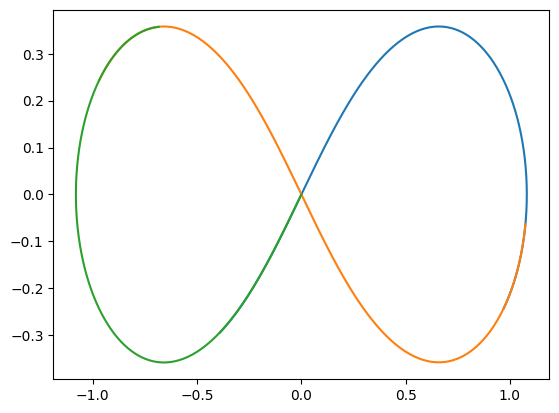

In [78]:
X = R[:,:,0]
Y = R[:,:,1]

plt.plot(X, Y, '-')

In [79]:
anim = animate(X, Y)

HTML(anim.to_html5_video())  # display animation
# anim.save('orbitss.mp4')  # save animation

100%|██████████| 251/251 [00:00<00:00, 288.35it/s]


## Conclusion and Discussion

In this workshop, we've journeyed from a straightforward, pure Python implementation of the $n$-body simulation to a highly optimized version that achieves a 1710x speedup.
We started by cleaning up our code with list comprehensions and cutting out unnecessary operations, then moved on to swapping slow functions for faster ones and leveraging high-performance libraries like NumPy.

The real game-changer came with Google `JAX`.
Its just-in-time compilation and GPU support pushed our code another order of magnitude in performance.
These optimizations show that Python, when used right, isn't just for quick-and-dirty prototypes.
It can also deliver serious speed and efficiency.

This is especially important in hackathons and rapid prototyping environments.
You can quickly iterate on your ideas and still end up with code that's robust enough for real-world applications.
Python truly bridges the gap between ease of development and high performance, letting you have your cake and eat it too.